<font size = 3, color = 'red'>
Tip: This is my first time to use python. So there may be some codes which seem to be naive. Welcome to provide any feedbacks.
    And also, I refer the code on the internet.

# (I) Import the Packages and Prepare Data

## 1) Import the Packages

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sma
import statsmodels as sm
import statsmodels.tsa.stattools as smtssttl
import random

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import MinMaxScaler

from keras.layers import LSTM, Input, Dense, Activation
from keras.models import Model, Sequential
from scipy.stats import bernoulli

from deap import base, creator, tools, algorithms
from bitstring import BitArray

## 2) Prepare the Data 

### 2.1) Read the Data

In [4]:
datay1 = pd.read_csv('GDPC1.csv')   # read the data
datay = datay1.rename(columns = {'GDPC1':'y'})   # change the name of column
datay1.head() 

,DATE,GDPC1
0,1947-01-01,2033.061
1,1947-04-01,2027.639
2,1947-07-01,2023.452
3,1947-10-01,2055.103
4,1948-01-01,2086.017


### 2.2) Prepare for the time series setting

In [5]:
date = pd.date_range('1947','2019-01-01',freq= 'Q')  # generate the date index and set the frequence
datay1.index = date
datay = datay1['GDPC1']  # get the data of GDP we need
datay.head()

1947-03-31    2033.061
1947-06-30    2027.639
1947-09-30    2023.452
1947-12-31    2055.103
1948-03-31    2086.017
Freq: Q-DEC, Name: GDPC1, dtype: float64

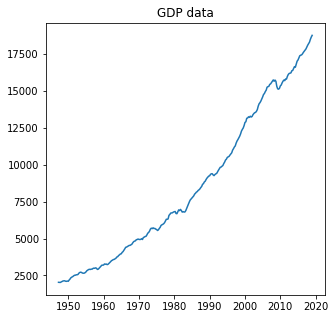

In [7]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(datay)
ax.set(title = 'GDP data')
plt.show()

# II) Traditional ARMA Methods

## 1) Basic Tests and Divide the Data Set

### 1.1) Stationary Test ------ Dicky-Fuller Test

In [8]:
def test_stationary(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    if dftest[1] < 0.05 and dftest[0] < dftest[4]['5%']:  # p value < 0.05, critical value
        print('Results of Dickey-Fuller Test: No Unit Root')
    else:
        print('Results of Dickey-Fuller Test: Unit Root')
test_stationary(datay)  # ensure stationary on 5% level

Results of Dickey-Fuller Test: Unit Root


### 1.2) Make the Series Stationary

In [9]:
data_logy_diff = np.log(datay).diff()  # log-difference
data_logy_diff = data_logy_diff[1:]
data_logy_diff.head()

1947-06-30   -0.002670
1947-09-30   -0.002067
1947-12-31    0.015521
1948-03-31    0.014931
1948-06-30    0.016372
Freq: Q-DEC, Name: GDPC1, dtype: float64

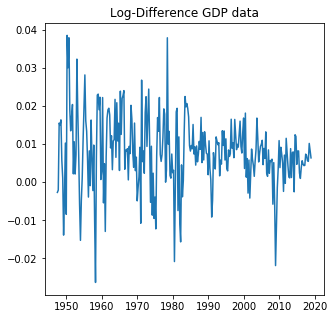

In [10]:
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(data_logy_diff)
ax.set(title = 'Log-Difference GDP data')
plt.show()

In [11]:
test_stationary(data_logy_diff) 

Results of Dickey-Fuller Test: No Unit Root


### 1.3) Seasoanlity Test 

<font size = 3> Tips: in fact just for sure b.c. it is seasoanl adjusted data

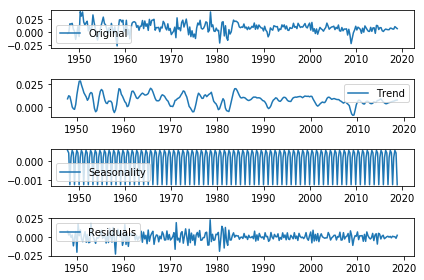

In [12]:
decomposition = seasonal_decompose(data_logy_diff,freq = 4)
 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
plt.subplot(411)
plt.plot(data_logy_diff, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<font size = 3, color = 'red'> There is very slight seasonality, which is very small comapring to other components of the series

### 1.4) Divide into Trainning Set and Test Set

In [13]:
split = 0.7  # trainning set: Test Set = 0.7:0.3
split_index = int(data_logy_diff.shape[0] * split)

train_stat = data_logy_diff[:split_index]
train_stat.head()

1947-06-30   -0.002670
1947-09-30   -0.002067
1947-12-31    0.015521
1948-03-31    0.014931
1948-06-30    0.016372
Freq: Q-DEC, Name: GDPC1, dtype: float64

In [14]:
test_stat = data_logy_diff[split_index:]
test_stat.head()

1997-06-30    0.016483
1997-09-30    0.012431
1997-12-31    0.008551
1998-03-31    0.009945
1998-06-30    0.009215
Freq: Q-DEC, Name: GDPC1, dtype: float64

<font size = 3, color = 'red'>
<b>Stage Result: We have finished preparing the data. Now the Data is stationary without seasonality and divided into trainning set and test set</b>

## 2) Decide the Order

### 2.1)  ACF, PACF

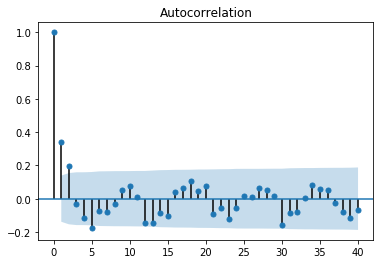

In [15]:
sma.graphics.tsa.plot_acf(train_stat,lags = 40)
plt.show()

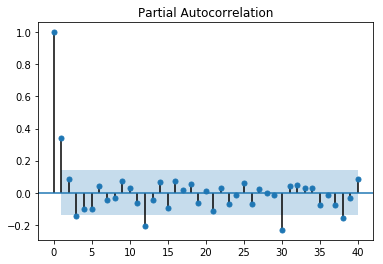

In [16]:
sma.graphics.tsa.plot_pacf(train_stat,lags = 40)
plt.show()

<font size = 3, color = 'red'>
According to the Graphs, the possible model is ARMA(1,2)

### 2.2) By Built-in Functions

In [34]:
order = smtssttl.arma_order_select_ic(train_stat,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.aic_min_order,order.bic_min_order,order.hqic_min_order

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWar

((3, 2), (1, 0), (3, 2))

<font size = 3, color = 'red'>
According to the results, the possible model is ARMA(3,2) and ARMA(1,0)

## 3) Model Fitting

### 3.1) ARMA(1,2)

In [17]:
model_12 = ARMA(train_stat, order=(1,2))  # fit a ARMA model, order is (1,2) if ARIMA, then use ARIMA(,order = (p,i,q))
result_arma_12 = model_12.fit(disp=-1, method='css')

NormaltestResult(statistic=8.030856659333223, pvalue=0.018035227872943607)


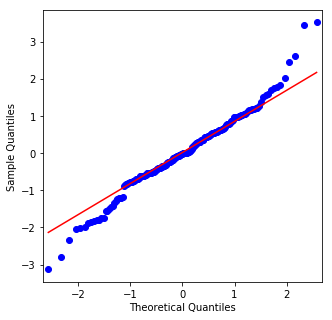

In [18]:
residual = result_arma_12.resid  # get the residuls

print(stats.normaltest(residual))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
fig = sm.graphics.api.qqplot(residual, line='q', ax=ax, fit=True) # QQ test
plt.show()

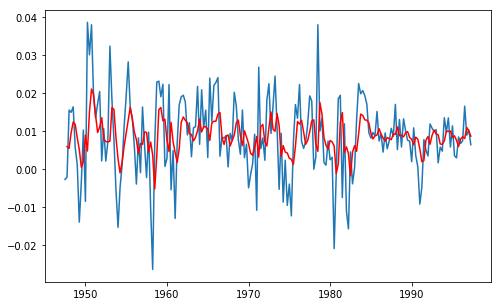

In [19]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(train_stat)
ax.plot(result_arma_12.fittedvalues, 'r')
plt.show()  # In-sample forecast v.s. original data

### 3.2) ARMA(3,2)

NormaltestResult(statistic=3.0593528599914115, pvalue=0.21660574309940975)


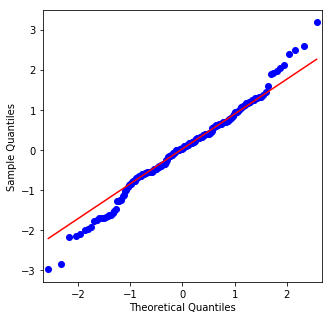

In [20]:
model_32 = ARMA(train_stat, order=(3,2)) 
result_arma_32 = model_32.fit(disp=-1, method='css')

residual = result_arma_32.resid

print(stats.normaltest(residual))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
fig = sm.graphics.api.qqplot(residual, line='q', ax=ax, fit=True)
plt.show()

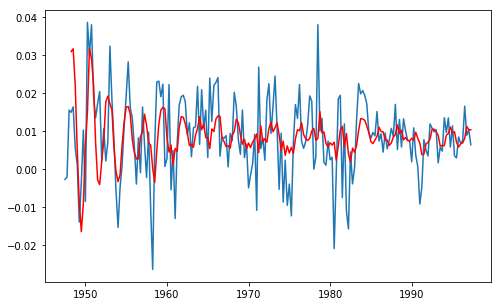

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(train_stat)
ax.plot(result_arma_32.fittedvalues, 'r')
plt.show()

### 3.3) ARMA(1,0)

NormaltestResult(statistic=7.0483275317341905, pvalue=0.029476446276216827)


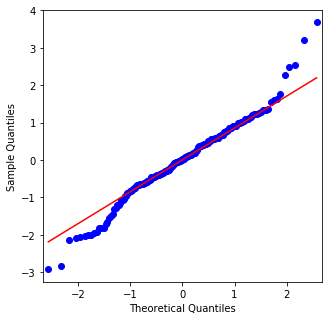

In [22]:
model_10 = ARMA(train_stat, order=(1,0))  
result_arma_10 = model_10.fit(disp=-1, method='css')

residual = result_arma_10.resid

print(stats.normaltest(residual))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
fig = sm.graphics.api.qqplot(residual, line='q', ax=ax, fit=True)
plt.show()

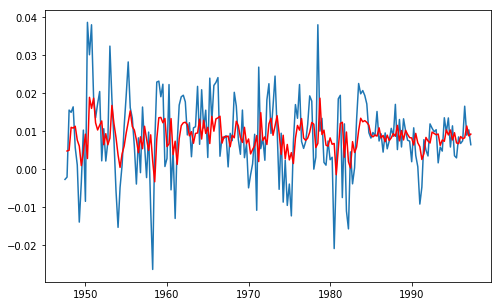

In [23]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax.plot(train_stat)
ax.plot(result_arma_10.fittedvalues, 'r')
plt.show()

### 3.4) In-Sample Results

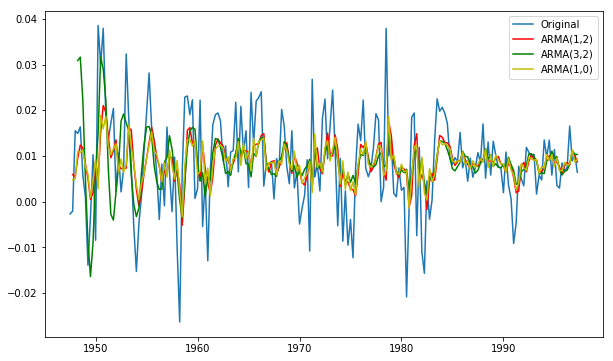

In [24]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(train_stat, label = 'Original')
ax.plot(result_arma_12.fittedvalues, 'r', label = 'ARMA(1,2)')
ax.plot(result_arma_32.fittedvalues, 'g',label = 'ARMA(3,2)')
ax.plot(result_arma_10.fittedvalues, 'y',label = 'ARMA(1,0)')
ax.legend()
plt.show()

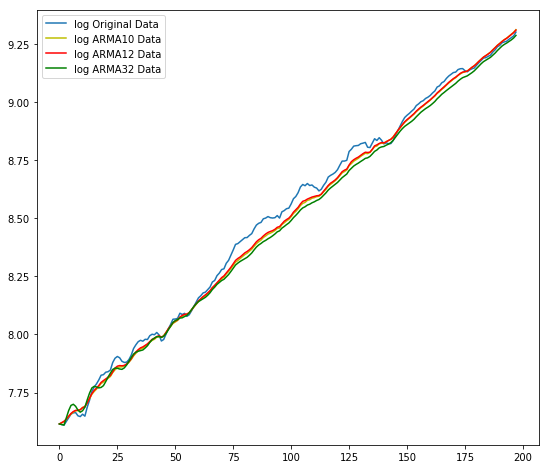

In [25]:
#original_train = np.exp()
length = np.shape(train_stat)[0]
original_train = np.zeros(length)
ARMA12_train = np.zeros(length)
ARMA10_train = np.zeros(length)
ARMA32_train = np.zeros(length)
original_train[0] = np.log(datay)[0]
original_train[1] = original_train[0] + train_stat[0]
ARMA12_train[0]  = np.log(datay)[0]
ARMA10_train[0]  = np.log(datay)[0]
ARMA32_train[0]  = np.log(datay)[0]
ARMA12_train[1]  = original_train[1]
ARMA10_train[1]  = original_train[1]
ARMA32_train[1]  = original_train[1]
length2 = np.shape(train_stat)[0]-3
for i in range(length2):
    original_train[i+2] = original_train[i+1] + train_stat[i]
    ARMA12_train[i+2] = ARMA12_train[i+1] + result_arma_12.fittedvalues[i]
    ARMA10_train[i+2] = ARMA10_train[i+1] + result_arma_10.fittedvalues[i]
ARMA32_train[2]  = original_train[2]
ARMA32_train[3]  = original_train[3]
length3 = np.shape(train_stat)[0]-4
for i in range(length3):
    ARMA32_train[i+4] = ARMA32_train[i+3] + result_arma_32.fittedvalues[i]

original_train = original_train[1:-1]
original_train_ex = np.exp(original_train)
ARMA10_train = ARMA10_train[1:-1]
ARMA10_train_ex = np.exp(ARMA10_train)
ARMA12_train = ARMA12_train[1:-1]
ARMA12_train_ex = np.exp(ARMA12_train)
ARMA32_train = ARMA32_train[1:-1]
ARMA32_train_ex = np.exp(ARMA32_train)

fig = plt.figure(figsize = (9,8))
ax = fig.add_subplot(111)
ax.plot(original_train, label = 'log Original Data')
ax.plot(ARMA10_train,'y', label = 'log ARMA10 Data')
ax.plot(ARMA12_train,'r', label = 'log ARMA12 Data')
ax.plot(ARMA32_train,'g', label = 'log ARMA32 Data')
ax.legend()
plt.show()

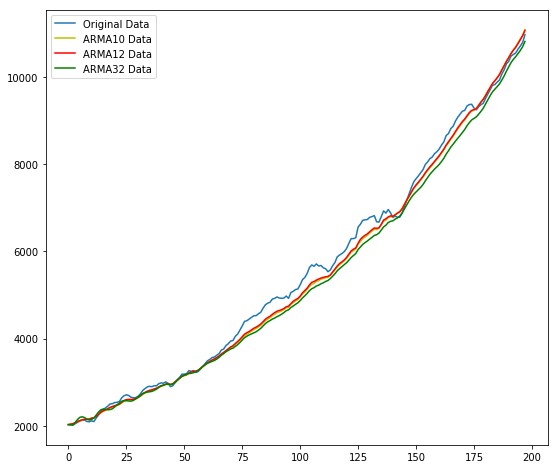

In [26]:
fig = plt.figure(figsize = (9,8))
ax = fig.add_subplot(111)
ax.plot(original_train_ex, label = 'Original Data')
ax.plot(ARMA10_train_ex,'y', label = 'ARMA10 Data')
ax.plot(ARMA12_train_ex,'r', label = 'ARMA12 Data')
ax.plot(ARMA32_train_ex,'g', label = 'ARMA32 Data')
ax.legend()
plt.show()

## 4) Forecast

### 4.1) ARMA(1,2)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


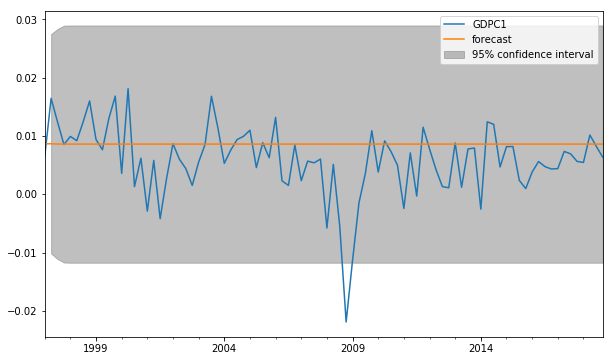

In [27]:
predict_dta_12 = result_arma_12.predict('1997-03-31', '2018-12-31', dynamic=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = data_logy_diff.loc['1997-03-31':].plot(ax=ax)

fig = result_arma_12.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)
plt.show()

In [28]:
rmse = np.sqrt(mean_squared_error(test_stat,predict_dta_12[1:]))
rmse  # Root of Mean Squarl error

0.006618977977436491

### 4.2) ARMA(3,2)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


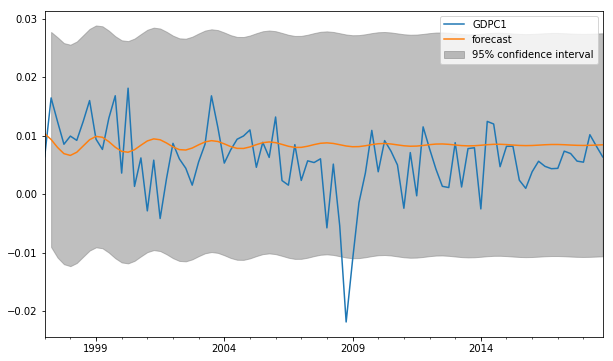

In [29]:
predict_dta_32 = result_arma_32.predict('1997-03-31', '2018-12-31', dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
ax = data_logy_diff.loc['1997-03-31':].plot(ax=ax)

fig = result_arma_32.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)
plt.show()

In [30]:
rmse = np.sqrt(mean_squared_error(test_stat, predict_dta_32[1:]))
rmse

0.006538694727582581

### 4.3) ARMA(1,0)

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


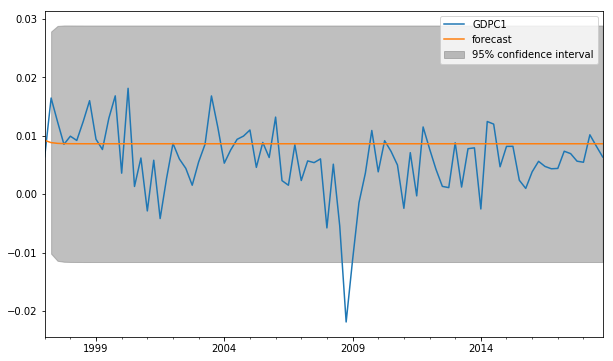

In [31]:
predict_dta_10 = result_arma_10.predict('1997-03-31', '2018-12-31', dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
ax = data_logy_diff.loc['1997-03-31':].plot(ax=ax)

fig = result_arma_10.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)
plt.show()

In [32]:
rmse = np.sqrt(mean_squared_error(test_stat,predict_dta_10[1:]))
rmse

0.006625208939842361

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


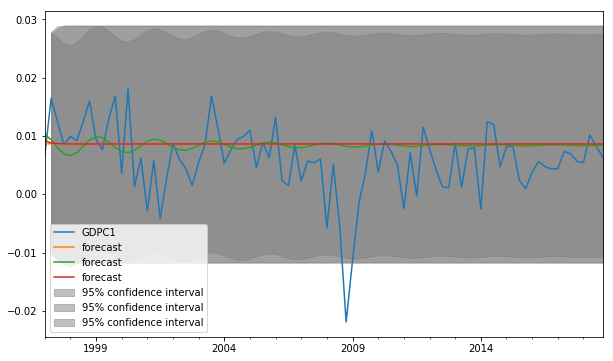

In [33]:
predict_dta_12 = result_arma_12.predict('1997-03-31', '2018-12-31', dynamic=True)
predict_dta_32 = result_arma_32.predict('1997-03-31', '2018-12-31', dynamic=True)
predict_dta_10 = result_arma_10.predict('1997-03-31', '2018-12-31', dynamic=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax = data_logy_diff.loc['1997-03-31':].plot(ax=ax)

fig = result_arma_12.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)#,label = 'ARMA(1,2) Forecast')
fig = result_arma_32.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)#,label = 'ARMA(3,2) Forecast')
fig = result_arma_10.plot_predict('1997-03-31', '2018-12-31', dynamic = True, ax=ax, plot_insample=False)#,label = 'ARMA(1,0) Forecast')

plt.show()

<font size = 3, color = 'red'>
<b> From the results above, we have the following conclusions:  
    
   1) The ARMA models fit well in trainning data  
   2) Although the RMSE is not low, but from graph, the Forecast is very bad
</b>

# III) LSTM

In [49]:
def load_data(dataset, sequence_length, split=0.7): # read the data and split into train and test set
    df = dataset
    data_all = np.array(df).astype(float)
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')

    x = reshaped_data[:, :-1]  # reshape the data to fit the requirements of input of LSTM
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y

def build_model():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=50, return_sequences=False)) # 1 layers
    #model.add(LSTM(50, return_sequences=True))
    #model.add(LSTM(50, return_sequences=False))
    model.add(Dense(output_dim=1))
    model.add(Activation('tanh'))  # activation function: relu, tanh, linear, sigmoid
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def train_model(train_x, train_y, test_x, test_y):
    model = build_model()

    try:
        model.fit(train_x, train_y, batch_size=10, epochs=30, validation_split=0.1) #batch_size for SGD, epoch times
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
    rmse = np.sqrt(mean_squared_error(test_y, predict)) # calculate the Root of mse
    return predict, test_y,rmse

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 179 samples, validate on 20 samples
Epoch 1/30
179/179 [==============================] - 7s 38ms/step - loss: 1.3804e-04 - val_loss: 1.7522e-05
Epoch 2/30
179/179 [==============================] - 0s 493us/step - loss: 1.1882e-04 - val_loss: 1.6861e-05
Epoch 3/30
179/179 [==============================] - 0s 552us/step - loss: 1.2629e-04 - val_loss: 1.5230e-05
Epoch 4/30
179/179 [==============================] - 0s 641us/step - loss: 1.2586e-04 - val_loss: 4.2875e-05
Epoch 5/30
179/179 [==============================] - 0s 635us/step - loss: 1.2653e-04 - val_loss: 2.7144e-05
Epoch 6/30
179/179 [==============================] - 0s 449us/step - loss: 1.2424e-04 - val_loss: 1.7949e-05
Epoch 7/30
179/179 [==============================] - 0s 488us/step - loss: 1.2747e-04 - val_loss: 2.6129e-05
Epoch 8/30
179/179 [==============================] - 0s 490us/step - loss: 1.2409e-04 - val_loss: 1.4686e-05
Epoch 9/30
179/179 [==============================] - 0s 646us/step - loss: 

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 178 samples, validate on 20 samples
Epoch 1/30
178/178 [==============================] - 7s 37ms/step - loss: 1.5147e-04 - val_loss: 1.6154e-05
Epoch 2/30
178/178 [==============================] - 0s 612us/step - loss: 1.2181e-04 - val_loss: 3.0631e-05
Epoch 3/30
178/178 [==============================] - 0s 588us/step - loss: 1.3118e-04 - val_loss: 3.7259e-05
Epoch 4/30
178/178 [==============================] - 0s 600us/step - loss: 1.2583e-04 - val_loss: 2.4053e-05
Epoch 5/30
178/178 [==============================] - 0s 600us/step - loss: 1.3852e-04 - val_loss: 2.5577e-05
Epoch 6/30
178/178 [==============================] - 0s 583us/step - loss: 1.2580e-04 - val_loss: 2.9233e-05
Epoch 7/30
178/178 [==============================] - 0s 572us/step - loss: 1.2759e-04 - val_loss: 3.7511e-05
Epoch 8/30
178/178 [==============================] - 0s 572us/step - loss: 1.2661e-04 - val_loss: 2.7686e-05
Epoch 9/30
178/178 [==============================] - 0s 555us/step - loss: 

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 178 samples, validate on 20 samples
Epoch 1/30
178/178 [==============================] - 10s 55ms/step - loss: 1.3922e-04 - val_loss: 2.2858e-05
Epoch 2/30
178/178 [==============================] - 0s 693us/step - loss: 1.2960e-04 - val_loss: 1.8503e-05
Epoch 3/30
178/178 [==============================] - 0s 794us/step - loss: 1.2794e-04 - val_loss: 1.6713e-05
Epoch 4/30
178/178 [==============================] - 0s 706us/step - loss: 1.2430e-04 - val_loss: 2.5907e-05
Epoch 5/30
178/178 [==============================] - 0s 745us/step - loss: 1.2734e-04 - val_loss: 1.7304e-05
Epoch 6/30
178/178 [==============================] - 0s 643us/step - loss: 1.3057e-04 - val_loss: 2.1345e-05
Epoch 7/30
178/178 [==============================] - 0s 672us/step - loss: 1.2644e-04 - val_loss: 5.5501e-05
Epoch 8/30
178/178 [==============================] - 0s 697us/step - loss: 1.2937e-04 - val_loss: 3.1066e-05
Epoch 9/30
178/178 [==============================] - 0s 1ms/step - loss: 1

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 177 samples, validate on 20 samples
Epoch 1/30
177/177 [==============================] - 8s 46ms/step - loss: 1.6604e-04 - val_loss: 5.2912e-05
Epoch 2/30
177/177 [==============================] - 0s 759us/step - loss: 1.2691e-04 - val_loss: 1.6776e-05
Epoch 3/30
177/177 [==============================] - 0s 773us/step - loss: 1.2846e-04 - val_loss: 1.6821e-05
Epoch 4/30
177/177 [==============================] - 0s 741us/step - loss: 1.3635e-04 - val_loss: 1.9779e-05
Epoch 5/30
177/177 [==============================] - 0s 816us/step - loss: 1.2471e-04 - val_loss: 3.1744e-05
Epoch 6/30
177/177 [==============================] - 0s 754us/step - loss: 1.3622e-04 - val_loss: 3.2125e-05
Epoch 7/30
177/177 [==============================] - 0s 789us/step - loss: 1.3248e-04 - val_loss: 5.8168e-05
Epoch 8/30
177/177 [==============================] - 0s 793us/step - loss: 1.3212e-04 - val_loss: 1.8379e-05
Epoch 9/30
177/177 [==============================] - 0s 734us/step - loss: 

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 176 samples, validate on 20 samples
Epoch 1/30
176/176 [==============================] - 9s 48ms/step - loss: 1.8394e-04 - val_loss: 1.7162e-05
Epoch 2/30
176/176 [==============================] - 0s 853us/step - loss: 1.3054e-04 - val_loss: 1.7704e-05
Epoch 3/30
176/176 [==============================] - 0s 1ms/step - loss: 1.2530e-04 - val_loss: 9.1970e-05
Epoch 4/30
176/176 [==============================] - 0s 2ms/step - loss: 1.4190e-04 - val_loss: 5.5842e-05
Epoch 5/30
176/176 [==============================] - 0s 2ms/step - loss: 1.2981e-04 - val_loss: 7.7878e-05
Epoch 6/30
176/176 [==============================] - 0s 2ms/step - loss: 1.2220e-04 - val_loss: 1.6755e-05
Epoch 7/30
176/176 [==============================] - 0s 2ms/step - loss: 1.3243e-04 - val_loss: 1.6702e-05
Epoch 8/30
176/176 [==============================] - 0s 1ms/step - loss: 1.2829e-04 - val_loss: 2.2187e-05
Epoch 9/30
176/176 [==============================] - 0s 880us/step - loss: 1.2591e-04 -

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 176 samples, validate on 20 samples
Epoch 1/30
176/176 [==============================] - 8s 47ms/step - loss: 1.6118e-04 - val_loss: 7.1995e-05
Epoch 2/30
176/176 [==============================] - 0s 1ms/step - loss: 1.4878e-04 - val_loss: 3.5272e-05
Epoch 3/30
176/176 [==============================] - 0s 964us/step - loss: 1.2729e-04 - val_loss: 1.8097e-05
Epoch 4/30
176/176 [==============================] - 0s 1ms/step - loss: 1.3087e-04 - val_loss: 1.5958e-04
Epoch 5/30
176/176 [==============================] - 0s 2ms/step - loss: 1.4143e-04 - val_loss: 1.8535e-05
Epoch 6/30
176/176 [==============================] - 0s 2ms/step - loss: 1.2759e-04 - val_loss: 4.3928e-05
Epoch 7/30
176/176 [==============================] - 0s 2ms/step - loss: 1.3458e-04 - val_loss: 2.6370e-05
Epoch 8/30
176/176 [==============================] - 0s 2ms/step - loss: 1.2416e-04 - val_loss: 1.7874e-05
Epoch 9/30
176/176 [==============================] - 0s 988us/step - loss: 1.2928e-04 -

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 175 samples, validate on 20 samples
Epoch 1/30
175/175 [==============================] - 11s 63ms/step - loss: 1.6172e-04 - val_loss: 1.7824e-05
Epoch 2/30
175/175 [==============================] - 0s 1ms/step - loss: 1.3717e-04 - val_loss: 2.8513e-05
Epoch 3/30
175/175 [==============================] - 0s 1ms/step - loss: 1.1454e-04 - val_loss: 1.8752e-05
Epoch 4/30
175/175 [==============================] - 0s 2ms/step - loss: 1.2565e-04 - val_loss: 1.7596e-05
Epoch 5/30
175/175 [==============================] - 0s 2ms/step - loss: 1.3860e-04 - val_loss: 4.0241e-05
Epoch 6/30
175/175 [==============================] - 0s 2ms/step - loss: 1.2875e-04 - val_loss: 1.0252e-04
Epoch 7/30
175/175 [==============================] - 0s 2ms/step - loss: 1.4275e-04 - val_loss: 3.9330e-05
Epoch 8/30
175/175 [==============================] - 0s 1ms/step - loss: 1.2906e-04 - val_loss: 2.5165e-05
Epoch 9/30
175/175 [==============================] - 0s 1ms/step - loss: 1.2714e-04 - va

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 174 samples, validate on 20 samples
Epoch 1/30
174/174 [==============================] - 9s 53ms/step - loss: 2.1433e-04 - val_loss: 2.0048e-04
Epoch 2/30
174/174 [==============================] - 0s 1ms/step - loss: 1.5461e-04 - val_loss: 9.4086e-05
Epoch 3/30
174/174 [==============================] - 0s 1ms/step - loss: 1.5346e-04 - val_loss: 7.4556e-05
Epoch 4/30
174/174 [==============================] - 0s 2ms/step - loss: 1.2703e-04 - val_loss: 1.7858e-05
Epoch 5/30
174/174 [==============================] - 1s 3ms/step - loss: 1.3565e-04 - val_loss: 3.4950e-05
Epoch 6/30
174/174 [==============================] - 1s 3ms/step - loss: 1.3675e-04 - val_loss: 3.5441e-05
Epoch 7/30
174/174 [==============================] - 1s 3ms/step - loss: 1.2293e-04 - val_loss: 2.0587e-05
Epoch 8/30
174/174 [==============================] - 0s 2ms/step - loss: 1.2580e-04 - val_loss: 7.8975e-05
Epoch 9/30
174/174 [==============================] - 0s 2ms/step - loss: 1.2691e-04 - val

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 173 samples, validate on 20 samples
Epoch 1/30
173/173 [==============================] - 9s 52ms/step - loss: 1.7794e-04 - val_loss: 3.9984e-05
Epoch 2/30
173/173 [==============================] - 0s 2ms/step - loss: 1.2224e-04 - val_loss: 4.8837e-05
Epoch 3/30
173/173 [==============================] - 0s 1ms/step - loss: 1.3901e-04 - val_loss: 2.9030e-05
Epoch 4/30
173/173 [==============================] - 0s 1ms/step - loss: 1.2907e-04 - val_loss: 1.7345e-05
Epoch 5/30
173/173 [==============================] - 0s 1ms/step - loss: 1.2714e-04 - val_loss: 2.0188e-05
Epoch 6/30
173/173 [==============================] - 0s 1ms/step - loss: 1.2869e-04 - val_loss: 1.7576e-05
Epoch 7/30
173/173 [==============================] - 0s 1ms/step - loss: 1.1779e-04 - val_loss: 2.1760e-05
Epoch 8/30
173/173 [==============================] - 0s 2ms/step - loss: 1.2819e-04 - val_loss: 4.3962e-05
Epoch 9/30
173/173 [==============================] - 1s 3ms/step - loss: 1.2388e-04 - val

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 173 samples, validate on 20 samples
Epoch 1/30
173/173 [==============================] - 9s 53ms/step - loss: 1.9318e-04 - val_loss: 4.1661e-05
Epoch 2/30
173/173 [==============================] - 0s 2ms/step - loss: 1.3099e-04 - val_loss: 1.0033e-04
Epoch 3/30
173/173 [==============================] - 0s 2ms/step - loss: 1.3134e-04 - val_loss: 8.0391e-05
Epoch 4/30
173/173 [==============================] - 0s 2ms/step - loss: 1.4651e-04 - val_loss: 7.5200e-05
Epoch 5/30
173/173 [==============================] - 1s 4ms/step - loss: 1.2733e-04 - val_loss: 7.5223e-05
Epoch 6/30
173/173 [==============================] - 1s 5ms/step - loss: 1.3036e-04 - val_loss: 8.8781e-05
Epoch 7/30
173/173 [==============================] - 0s 3ms/step - loss: 1.3968e-04 - val_loss: 5.3534e-05
Epoch 8/30
173/173 [==============================] - 0s 2ms/step - loss: 1.2995e-04 - val_loss: 2.0425e-05
Epoch 9/30
173/173 [==============================] - 0s 2ms/step - loss: 1.2743e-04 - val

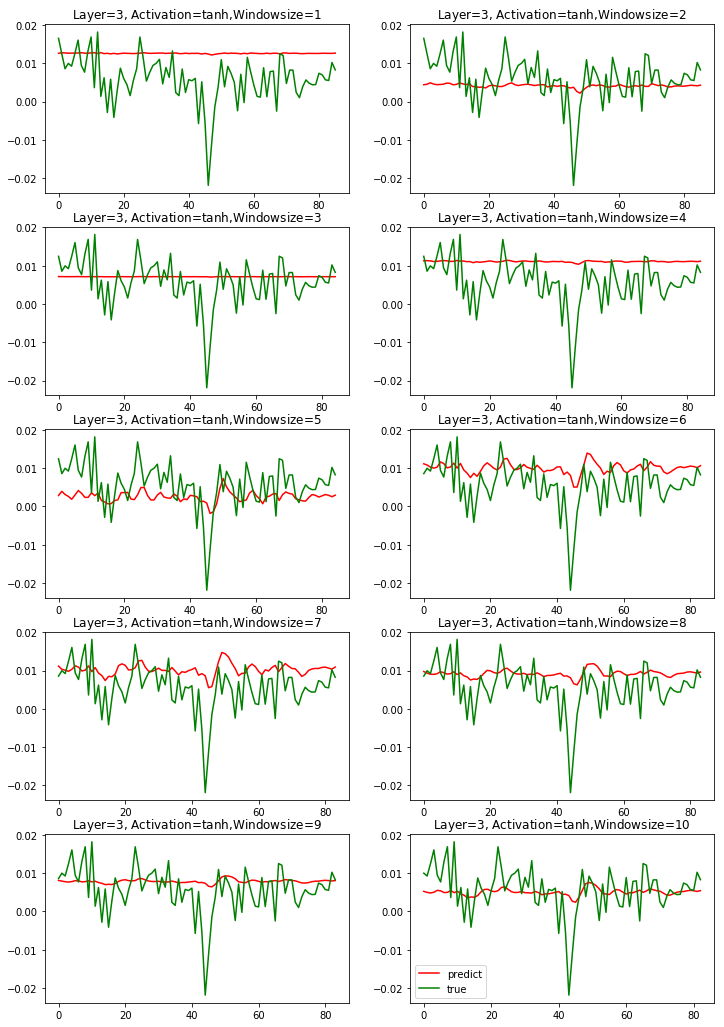

In [67]:
if __name__ == '__main__':
    RMSE = np.zeros(10)
    num_rows, num_cols = 5,2
    fig, axes = plt.subplots(num_rows, num_cols, figsize = (12,18))
    for i in range(num_rows):
        for j in range(num_cols):
            n = 2 * i + j + 1
            train_x, train_y, test_x, test_y = load_data(data_logy_diff,n)  # get the data, window size = n
            train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) # reshape the data
            test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1)) 
            predict_y, test_y,rmse_LSTM = train_model(train_x, train_y, test_x, test_y) # fit model, get predictons
            RMSE[n-1] = rmse_LSTM # get the rmse
            axes[i,j].plot(predict_y, 'r') # plot the subgraphs
            axes[i,j].plot(test_y, 'g-')
            plt.legend(['predict', 'true'])
            t = f'Layer=3, Activation=tanh,Windowsize=${n}$'
            axes[i,j].set(title = t)
    plt.show()   

In [68]:
RMSE

array([0.00901491, 0.00612535, 0.00612311, 0.00797342, 0.0065112 ,
       0.00713503, 0.00734397, 0.00676397, 0.00624379, 0.00584187])

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 177 samples, validate on 20 samples
Epoch 1/30
177/177 [==============================] - 1s 4ms/step - loss: 1.7489e-04 - val_loss: 5.8516e-05
Epoch 2/30
177/177 [==============================] - 0s 372us/step - loss: 1.3091e-04 - val_loss: 2.8778e-05
Epoch 3/30
177/177 [==============================] - 0s 254us/step - loss: 1.2292e-04 - val_loss: 4.3539e-05
Epoch 4/30
177/177 [==============================] - 0s 248us/step - loss: 1.2220e-04 - val_loss: 2.3674e-05
Epoch 5/30
177/177 [==============================] - 0s 254us/step - loss: 1.2529e-04 - val_loss: 2.8852e-05
Epoch 6/30
177/177 [==============================] - 0s 282us/step - loss: 1.1959e-04 - val_loss: 2.7512e-05
Epoch 7/30
177/177 [==============================] - 0s 237us/step - loss: 1.1738e-04 - val_loss: 2.8287e-05
Epoch 8/30
177/177 [==============================] - 0s 259us/step - loss: 1.1786e-04 - val_loss: 2.2863e-05
Epoch 9/30
177/177 [==============================] - 0s 276us/step - loss: 1

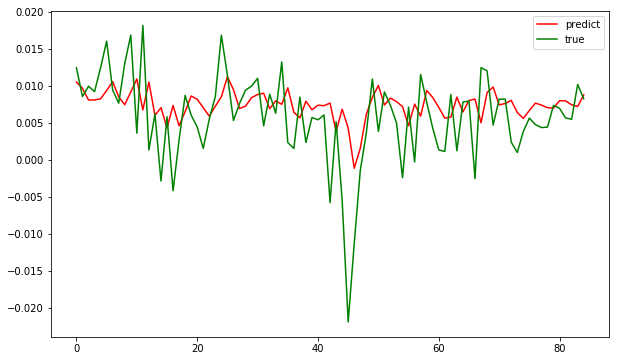

In [50]:
if __name__ == '__main__':
    train_x, train_y, test_x, test_y = load_data(data_logy_diff,4) 
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) 
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1)) 
    predict_y, test_y,rmse_LSTM = train_model(train_x, train_y, test_x, test_y)
    fig2 = plt.figure(figsize = (10,6))
    plt.plot(predict_y, 'r')
    plt.plot(test_y, 'g-')
    plt.legend(['predict', 'true'])
    plt.show()  # choose the best model: tanh, 1 layer, window size = 4

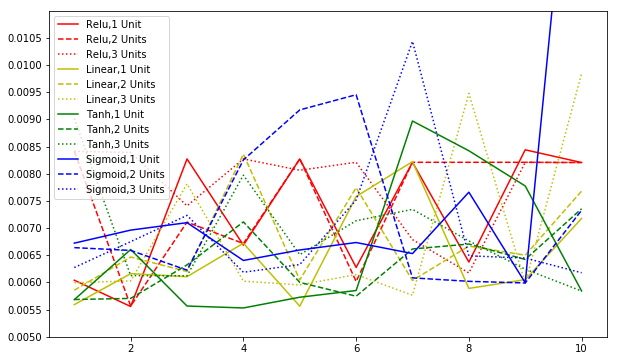

In [38]:
r1 = [0.00604094, 0.0055575 , 0.00827216, 0.00668619, 0.00827216, 0.00627636, 0.00820998, 0.0063748 , 0.00843996, 0.00820577]
l1 = [0.00559173, 0.00616175, 0.00610593, 0.00672123, 0.00556319, 0.00757958, 0.00822243, 0.00589028, 0.00605148, 0.00717616]
t1 = [0.00568353, 0.00660648, 0.00556596, 0.00553071, 0.0057279 , 0.00585148, 0.0089696 , 0.00842246, 0.00777481, 0.00584335]
s1 = [0.00672286, 0.0069627 , 0.00709984, 0.00640445, 0.00659728, 0.0067344 , 0.00653081, 0.00766027, 0.00599445, 0.01653618]
r2 = [0.00841382, 0.00556553, 0.00711029, 0.00671599, 0.00827216, 0.00601818, 0.00820998, 0.00820998, 0.00820998, 0.00820577]
l2 = [0.00585698, 0.00646719, 0.00620064, 0.00836052, 0.00604696, 0.00774258, 0.00603605, 0.00666932, 0.00650147, 0.00767977]
t2 = [0.00568619, 0.00570609, 0.00632323, 0.00711328, 0.00600067, 0.0057466 , 0.00661579, 0.00670644, 0.00642299, 0.00735558]
s2 = [0.00664024, 0.00658894, 0.00622573, 0.00825466, 0.00917385, 0.0094532 , 0.00608407, 0.00602036, 0.00599026, 0.00732717]
r3 = [0.00841382, 0.00838983, 0.00740884, 0.00827216, 0.00806395, 0.00820998, 0.006788  , 0.00617445, 0.00820998, 0.00820577]
l3 = [0.00599508, 0.0060281 , 0.0078136 , 0.00602351, 0.00595458, 0.00614449, 0.0057648 , 0.00947862, 0.00598424, 0.00984306]
s3 = [0.00627451, 0.00675045, 0.00723387, 0.00618711, 0.006329  , 0.00751778, 0.01043421, 0.00648967, 0.0064484 , 0.00617824]
t3 = [0.00901491, 0.00612535, 0.00612311, 0.00797342, 0.0065112 , 0.00713503, 0.00734397, 0.00676397, 0.00624379, 0.00584187]
fig, ax = plt.subplots(figsize = (10,6))
w = np.linspace(1,10,10)
ax.plot(w,r1,'r', label = 'Relu,1 Unit')
ax.plot(w,r2,'r--', label = 'Relu,2 Units')
ax.plot(w,r3,'r:', label = 'Relu,3 Units')
ax.plot(w,l1,'y',label = 'Linear,1 Unit')
ax.plot(w,l2,'y--',label = 'Linear,2 Units')
ax.plot(w,l3,'y:',label = 'Linear,3 Units')
ax.plot(w,t1,'g',label = 'Tanh,1 Unit')
ax.plot(w,t2,'g--',label = 'Tanh,2 Units')
ax.plot(w,t3,'g:',label = 'Tanh,3 Units')
ax.plot(w,s1,'b',label = 'Sigmoid,1 Unit')
ax.plot(w,s2,'b--',label = 'Sigmoid,2 Units')
ax.plot(w,s3,'b:',label = 'Sigmoid,3 Units')
ax.legend()
ax.set_ylim([0.005,0.011])
y_ticks = np.arange(0.005,0.011,0.0005)
plt.yticks(y_ticks)
#plt.hlines(0, 0, 5, colors = "c", linestyles = "dashed")
plt.show()


<font size = 3, color = 'red'>
<b>
Stage Conclusion: From the results of LSTM, we have the following conclusions:  
        
   1) The number of LSTM (layers of the NN) matters, Too high number may be harmful, when n.layer = 1 and 2, the results are good, but when n.layers = 3, the results, with other setting the same, behave bad.  
    2) Linear or tanh activation function behave best, relu function behaves OK, sigmoid function behaves worst.  
    3) window size matters, too high or too low window size both behave bad.  
    4) LSTM's results behave better than ARMA
</b>

# IV) LSTM with GA for window size and number of unit choice

In [51]:
np.random.seed(7)

In [52]:
data = pd.read_csv('GDPC1.csv')
data1 = data['GDPC1']
data1 = np.log(data1).diff()
data1 = np.reshape(np.array(data1[:]),(len(data1[:]),1))

data1 = data1[1:,]

In [53]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    X,Y = prepare_dataset(data1,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.30, random_state = 7)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(X_train, y_train, epochs=10, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [54]:
population_size = 50
num_generations = 8
gene_length = 10

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.3, mutpb = 0.2, ngen = num_generations, verbose = False)


Window Size:  23 , Num of Units:  8
Epoch 1/10
184/184 [==============================] - 1s 5ms/step - loss: 8.9151e-05
Epoch 2/10
184/184 [==============================] - 0s 1ms/step - loss: 8.3396e-05
Epoch 3/10
184/184 [==============================] - 0s 1ms/step - loss: 7.8379e-05
Epoch 4/10
184/184 [==============================] - 0s 1ms/step - loss: 7.3868e-05
Epoch 5/10
184/184 [==============================] - 0s 1ms/step - loss: 7.5020e-05
Epoch 6/10
184/184 [==============================] - 0s 1ms/step - loss: 7.6694e-05
Epoch 7/10
 60/184 [========>.....................] - ETA: 0s - loss: 7.6418e-05

KeyboardInterrupt: 

In [ ]:
# Print top N solutions
best_individuals = tools.selBest(population,k = 5)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)

<font size = 3> best result: (37,10), (2,0), (48,0)

In [56]:
best_window_size = 37
best_num_units = 10
X,Y = prepare_dataset(data1,window_size)
X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.30, random_state = 7)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
y_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/5
174/174 [==============================] - 1s 6ms/step - loss: 8.7544e-05
Epoch 2/5
174/174 [==============================] - 0s 2ms/step - loss: 8.5836e-05
Epoch 3/5
174/174 [==============================] - 0s 2ms/step - loss: 8.5759e-05
Epoch 4/5
174/174 [==============================] - 0s 2ms/step - loss: 8.1942e-05
Epoch 5/5
174/174 [==============================] - 0s 2ms/step - loss: 8.3302e-05
Test RMSE:  0.009337764011846925


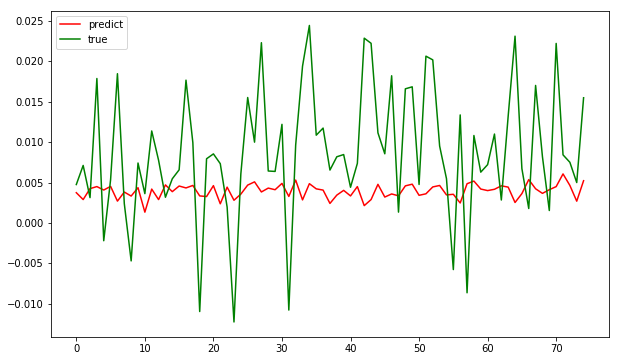

In [57]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_pred,'r')
ax.plot(y_val,'g-')
plt.legend(['predict', 'true'])
plt.show()

# V) Forecasting on Generated ARMA data

## 1) Generate data

<font size = 3, color = 'blue'> We assume a time sereis ARMA(2,2) data, which has 1000 observations.  
  
  $$
   x_t = 0.4 \cdot x_{t-1} + 0.2 \cdot x_{t-2} + u_t + 0.1 \cdot u_{t-1} + 0.5 \cdot u_{t-2}
$$

### 1.1) No Changes on $Var(u)$

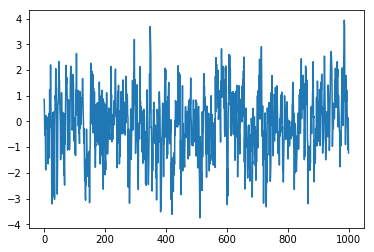

In [75]:
np.random.seed(7)
u = np.random.randn(1,1002)

x = np.zeros(1002)
x[0] = u[0,0]
x[1] = u[0,1]

for i in range(1000):
    x[i+2] = 0.3 * x[i+1] + 0.1 * x[i] + u[0,i+2] + 0.1 * u[0,i+1] + 0.5 * u[0,i]
x = x[2:]
dta_arma_nc = x
plt.plot(dta_arma_nc)
plt.show()

### 1.2) Changes on $var(u)$

<font size = 3, color = 'blue'> $t \in [1,500], var(u_t) = 1$, $t \in [501,1000], var(u_t) = 0.5$

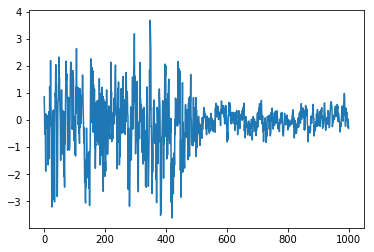

In [126]:
e = u
for i in range(500):
    n = i+502
    e[0,n] = u[0,n]* (0.5**2) 

y = np.zeros(1002)
y[0] = u[0,0]
y[1] = u[0,1]

for i in range(1000):
    y[i+2] = 0.3 * y[i+1] + 0.1 * y[i] + e[0,i+2] + 0.1 * e[0,i+1] + 0.5 * e[0,i]
y = y[2:]

dta_arma_c = y
plt.plot(dta_arma_c)
plt.show()

## 2) Forecasting

### 2.1) Data without Structural Changes

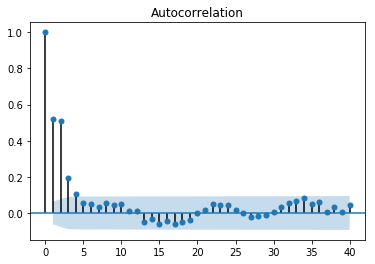

In [77]:
sma.graphics.tsa.plot_acf(dta_arma_nc,lags = 40)
plt.show()

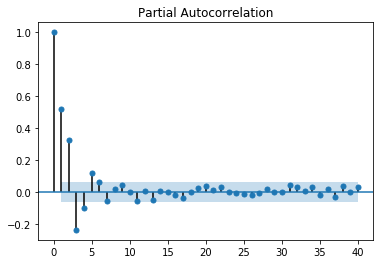

In [78]:
sma.graphics.tsa.plot_pacf(dta_arma_nc,lags = 40)
plt.show()

<font size = 3, color = 'red'> According to the graph, the result is (3,3)

In [ ]:
#order_x = smtssttl.arma_order_select_ic(x,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
#order_x.aic_min_order,order_x.bic_min_order,order_x.hqic_min_order

<font size = 3, color = 'red'> The result is (1,3),(1,2),(1,2)

In [93]:
dta_arma_nc = pd.Series(dta_arma_nc)
split = 0.7  # trainning set: Test Set = 0.7:0.3
split_index = int(dta_arma_nc.shape[0] * split)

train_dta_arma_nc = dta_arma_nc[:split_index]
test_dta_arma_nc = dta_arma_nc[split_index:]

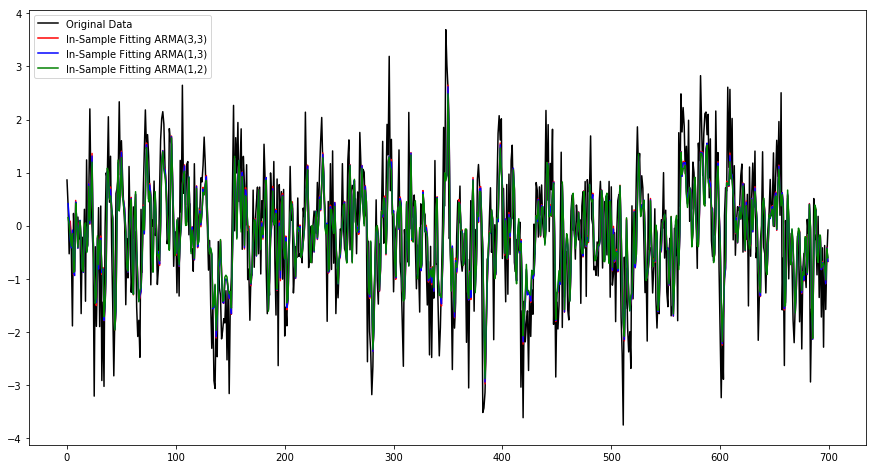

In [113]:
nc_model_33 = ARMA(train_dta_arma_nc, order=(3,3))  
nc_result_arma_33 = nc_model_33.fit(disp=-1, method='css')
nc_model_13 = ARMA(train_dta_arma_nc, order=(1,3))  
nc_result_arma_13 = nc_model_13.fit(disp=-1, method='css')
nc_model_12 = ARMA(train_dta_arma_nc, order=(1,2))  
nc_result_arma_12 = nc_model_12.fit(disp=-1, method='css')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(train_dta_arma_nc,'black',label = 'Original Data')
ax.plot(nc_result_arma_33.fittedvalues, 'r',label = 'In-Sample Fitting ARMA(3,3)')
ax.plot(nc_result_arma_13.fittedvalues, 'b',label = 'In-Sample Fitting ARMA(1,3)')
ax.plot(nc_result_arma_12.fittedvalues, 'g',label = 'In-Sample Fitting ARMA(1,2)')
ax.legend()
plt.show()

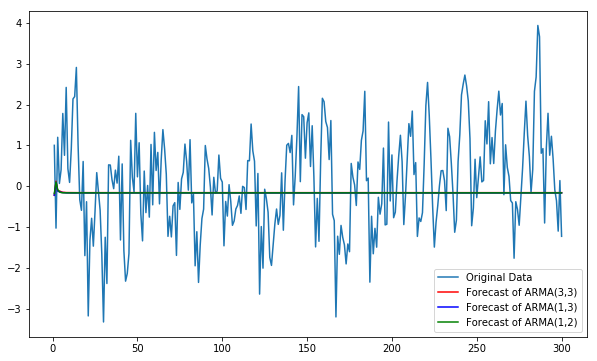

In [114]:
nc_predict_arma_33 = nc_result_arma_33.predict(700, 999, dynamic=True)
nc_predict_arma_13 = nc_result_arma_13.predict(700,999, dynamic=True)
nc_predict_arma_12 = nc_result_arma_12.predict(700,999, dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
t = np.linspace(1,300,300)
ax.plot(t,test_dta_arma_nc, label = 'Original Data')
ax.plot(t,nc_predict_arma_33,'r', label = 'Forecast of ARMA(3,3)')
ax.plot(t,nc_predict_arma_13,'b', label = 'Forecast of ARMA(1,3)')
ax.plot(t,nc_predict_arma_12,'g', label = 'Forecast of ARMA(1,2)')
ax.legend()

plt.show()

In [134]:
rmse = np.sqrt(mean_squared_error(test_dta_arma_nc,nc_predict_arma_33))
rmse

1.24584305701933

In [137]:
rmse = np.sqrt(mean_squared_error(test_dta_arma_nc,nc_predict_arma_13))
rmse

1.2472496524753156

In [139]:
rmse = np.sqrt(mean_squared_error(test_dta_arma_nc,nc_predict_arma_12))
rmse

1.2468557988203401

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 626 samples, validate on 70 samples
Epoch 1/30
626/626 [==============================] - 1s 2ms/step - loss: 1.3709 - val_loss: 1.0611
Epoch 2/30
626/626 [==============================] - 0s 263us/step - loss: 1.2457 - val_loss: 1.0142
Epoch 3/30
626/626 [==============================] - 0s 277us/step - loss: 1.1689 - val_loss: 0.9937
Epoch 4/30
626/626 [==============================] - 0s 272us/step - loss: 1.1231 - val_loss: 0.9817
Epoch 5/30
626/626 [==============================] - 0s 263us/step - loss: 1.1054 - val_loss: 0.9849
Epoch 6/30
626/626 [==============================] - 0s 252us/step - loss: 1.0985 - val_loss: 0.9898
Epoch 7/30
626/626 [==============================] - 0s 274us/step - loss: 1.0944 - val_loss: 0.9767
Epoch 8/30
626/626 [==============================] - 0s 263us/step - loss: 1.0900 - val_loss: 0.9787
Epoch 9/30
626/626 [==============================] - 0s 266us/step - loss: 1.0797 - val_loss: 0.9469
Epoch 10/30
626/626 [==================

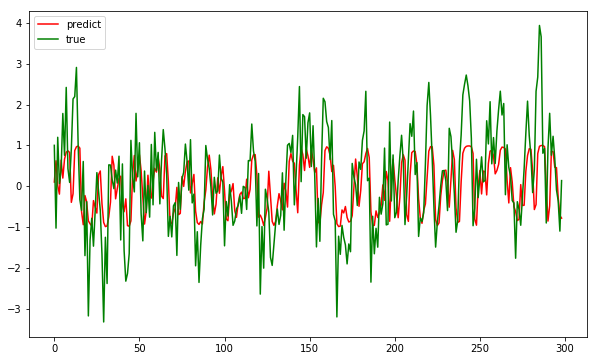

In [147]:
def load_data(dataset, sequence_length, split=0.7): # read the data and split into train and test set
    df = dataset
    data_all = np.array(df).astype(float)
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')

    x = reshaped_data[:, :-1]  # reshape the data to fit the requirements of input of LSTM
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y

def build_model():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=50, return_sequences=False)) # 1 layers
    #model.add(LSTM(50, return_sequences=True))
    #model.add(LSTM(50, return_sequences=False))
    model.add(Dense(output_dim=1))
    model.add(Activation('tanh'))  # activation function: relu, tanh, linear, sigmoid
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def train_model(train_x, train_y, test_x, test_y):
    model = build_model()

    try:
        model.fit(train_x, train_y, batch_size=10, epochs=30, validation_split=0.1) #batch_size for SGD, epoch times
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
    rmse = np.sqrt(mean_squared_error(test_y, predict)) # calculate the Root of mse
    return predict, test_y,rmse

if __name__ == '__main__':
    fig, axes = plt.subplots( figsize = (10,6))
    train_x, train_y, test_x, test_y = load_data(dta_arma_nc,4)  # get the data, window size = n
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) # reshape the data
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1)) 
    predict_y, test_y,rmse_LSTM_nc = train_model(train_x, train_y, test_x, test_y) # fit model, get predictons
    axes.plot(predict_y, 'r') # plot the subgraphs
    axes.plot(test_y, 'g-')
    plt.legend(['predict', 'true'])
    plt.show()   

In [148]:
rmse_LSTM_nc

0.9965266617383296

### 2.2) Data with Structural Changes

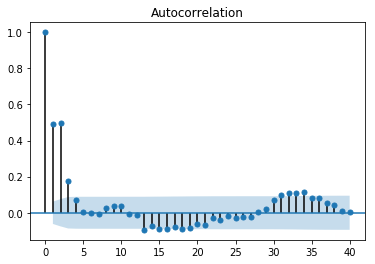

In [127]:
sma.graphics.tsa.plot_acf(dta_arma_c,lags = 40)
plt.show()

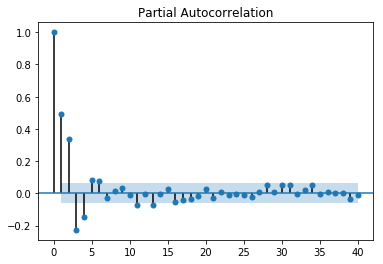

In [128]:
sma.graphics.tsa.plot_pacf(dta_arma_c,lags = 40)
plt.show()

<font size = 3, color = 'red'> According to the graph, the result is (3,4)

In [129]:
order_y = smtssttl.arma_order_select_ic(y,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order_y.aic_min_order,order_y.bic_min_order,order_y.hqic_min_order

((1, 2), (1, 2), (1, 2))

In [130]:
dta_arma_c = pd.Series(dta_arma_c)
split = 0.7  # trainning set: Test Set = 0.7:0.3
split_index = int(dta_arma_c.shape[0] * split)

train_dta_arma_c = dta_arma_c[:split_index]
test_dta_arma_c = dta_arma_c[split_index:]

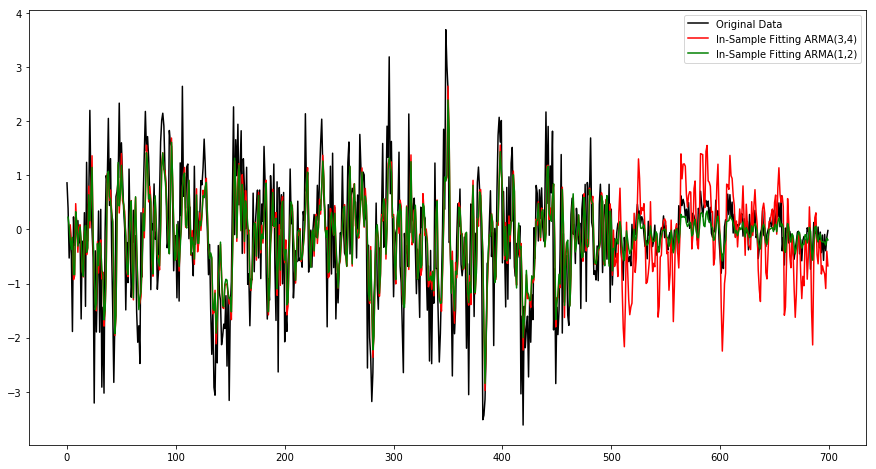

In [131]:
c_model_34 = ARMA(train_dta_arma_c, order=(3,4))  
c_result_arma_34 = c_model_33.fit(disp=-1, method='css')
c_model_12 = ARMA(train_dta_arma_c, order=(1,2))  
c_result_arma_12 = c_model_12.fit(disp=-1, method='css')

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.plot(train_dta_arma_c,'black',label = 'Original Data')
ax.plot(c_result_arma_34.fittedvalues, 'r',label = 'In-Sample Fitting ARMA(3,4)')
ax.plot(c_result_arma_12.fittedvalues, 'g',label = 'In-Sample Fitting ARMA(1,2)')
ax.legend()
plt.show()

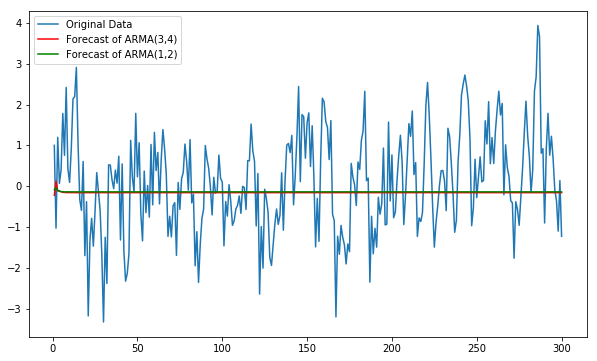

In [132]:
c_predict_arma_34 = c_result_arma_34.predict(700, 999, dynamic=True)
c_predict_arma_12 = c_result_arma_12.predict(700,999, dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
t = np.linspace(1,300,300)
ax.plot(t,test_dta_arma_nc, label = 'Original Data')
ax.plot(t,c_predict_arma_34,'r', label = 'Forecast of ARMA(3,4)')
ax.plot(t,c_predict_arma_12,'g', label = 'Forecast of ARMA(1,2)')
ax.legend()

plt.show()

In [140]:
rmse = np.sqrt(mean_squared_error(test_dta_arma_c,c_predict_arma_34))
rmse

0.35758047872800247

In [141]:
rmse = np.sqrt(mean_squared_error(test_dta_arma_c,c_predict_arma_12))
rmse

0.3472331980666724

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=50)`
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Train on 626 samples, validate on 70 samples
Epoch 1/30
626/626 [==============================] - 1s 2ms/step - loss: 1.0618 - val_loss: 0.0645
Epoch 2/30
626/626 [==============================] - 0s 263us/step - loss: 0.9789 - val_loss: 0.0633
Epoch 3/30
626/626 [==============================] - 0s 382us/step - loss: 0.9305 - val_loss: 0.0629
Epoch 4/30
626/626 [==============================] - 0s 598us/step - loss: 0.9024 - val_loss: 0.0663
Epoch 5/30
626/626 [==============================] - 0s 575us/step - loss: 0.8910 - val_loss: 0.0660
Epoch 6/30
626/626 [==============================] - 0s 603us/step - loss: 0.8812 - val_loss: 0.0679
Epoch 7/30
626/626 [==============================] - 0s 557us/step - loss: 0.8794 - val_loss: 0.0689
Epoch 8/30
626/626 [==============================] - 0s 262us/step - loss: 0.8789 - val_loss: 0.0691
Epoch 9/30
626/626 [==============================] - 0s 274us/step - loss: 0.8760 - val_loss: 0.0685
Epoch 10/30
626/626 [==================

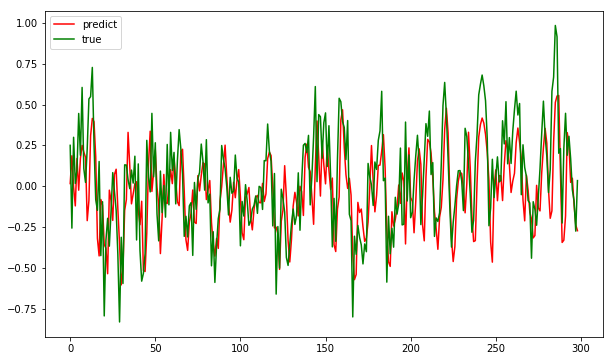

In [149]:
def load_data(dataset, sequence_length, split=0.7): # read the data and split into train and test set
    df = dataset
    data_all = np.array(df).astype(float)
    data = []
    for i in range(len(data_all) - sequence_length - 1):
        data.append(data_all[i: i + sequence_length + 1])
    reshaped_data = np.array(data).astype('float64')

    x = reshaped_data[:, :-1]  # reshape the data to fit the requirements of input of LSTM
    y = reshaped_data[:, -1]
    split_boundary = int(reshaped_data.shape[0] * split)
    train_x = x[: split_boundary]
    test_x = x[split_boundary:]

    train_y = y[: split_boundary]
    test_y = y[split_boundary:]

    return train_x, train_y, test_x, test_y

def build_model():
    model = Sequential()
    model.add(LSTM(input_dim=1, output_dim=50, return_sequences=False)) # 1 layers
    #model.add(LSTM(50, return_sequences=True))
    #model.add(LSTM(50, return_sequences=False))
    model.add(Dense(output_dim=1))
    model.add(Activation('tanh'))  # activation function: relu, tanh, linear, sigmoid
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def train_model(train_x, train_y, test_x, test_y):
    model = build_model()

    try:
        model.fit(train_x, train_y, batch_size=10, epochs=30, validation_split=0.1) #batch_size for SGD, epoch times
        predict = model.predict(test_x)
        predict = np.reshape(predict, (predict.size, ))
    except KeyboardInterrupt:
        print(predict)
        print(test_y)
    rmse = np.sqrt(mean_squared_error(test_y, predict)) # calculate the Root of mse
    return predict, test_y,rmse

if __name__ == '__main__':
    fig, axes = plt.subplots( figsize = (10,6))
    train_x, train_y, test_x, test_y = load_data(dta_arma_c,4)  # get the data, window size = n
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1)) # reshape the data
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1)) 
    predict_y, test_y,rmse_LSTM_c = train_model(train_x, train_y, test_x, test_y) # fit model, get predictons
    axes.plot(predict_y, 'r') # plot the subgraphs
    axes.plot(test_y, 'g-')
    plt.legend(['predict', 'true'])
    plt.show()   

In [150]:
rmse_LSTM_c

0.25255415956815824